In [1]:
import evoVAE.utils.visualisation as vs 
import evoVAE.utils.seq_tools as st
import yaml
from evoVAE.models.seqVAE import SeqVAE
from evoVAE.utils.datasets import MSA_Dataset
import pandas as pd
import torch
import numpy as np
import igraph as ig
from igraph import Graph

In [2]:
with open("../data/dummy_config.yaml", "r") as stream:
    settings = yaml.safe_load(stream)

Cassowary 

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/cassowary/vis/tree_1_ancestors_extants.fasta
Checking for bad characters: ['B', 'J', 'Z', 'U']
Number of seqs: 485


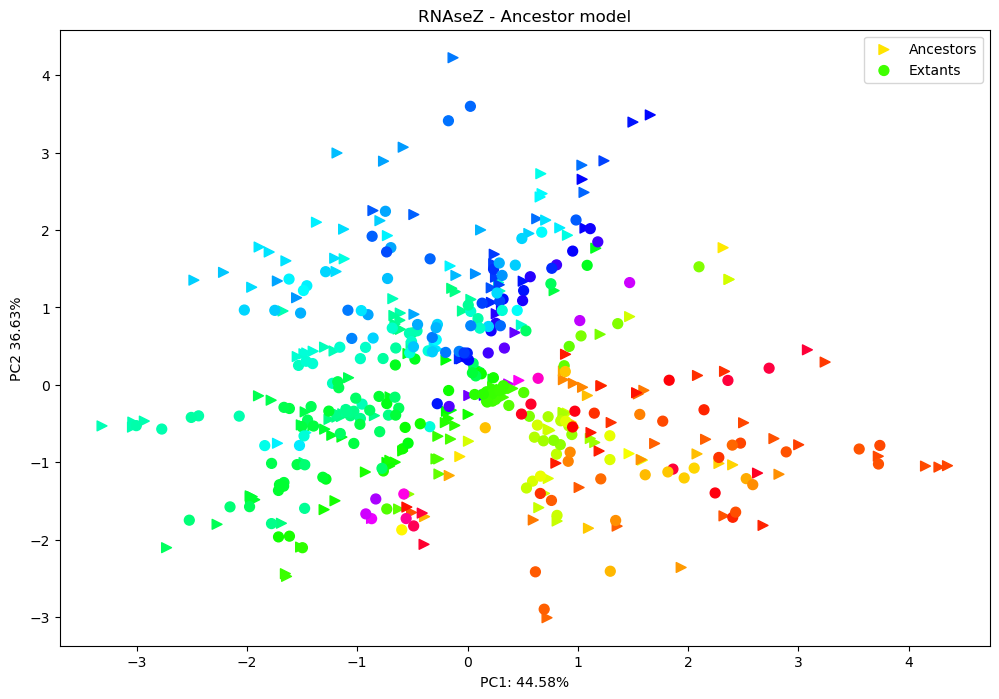

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/cassowary/vis/tree_1_ancestors_extants.fasta
Checking for bad characters: ['B', 'J', 'Z', 'U']
Number of seqs: 485


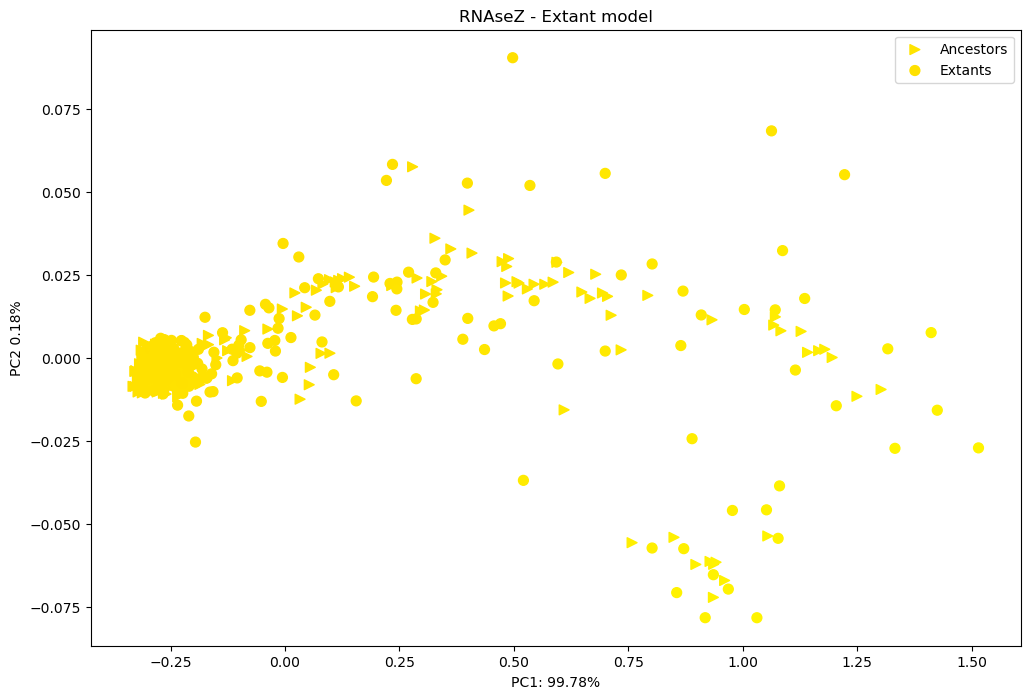

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/cassowary/vis/tree_1_ancestors_extants.fasta
Checking for bad characters: ['B', 'J', 'Z', 'U']
Number of seqs: 485


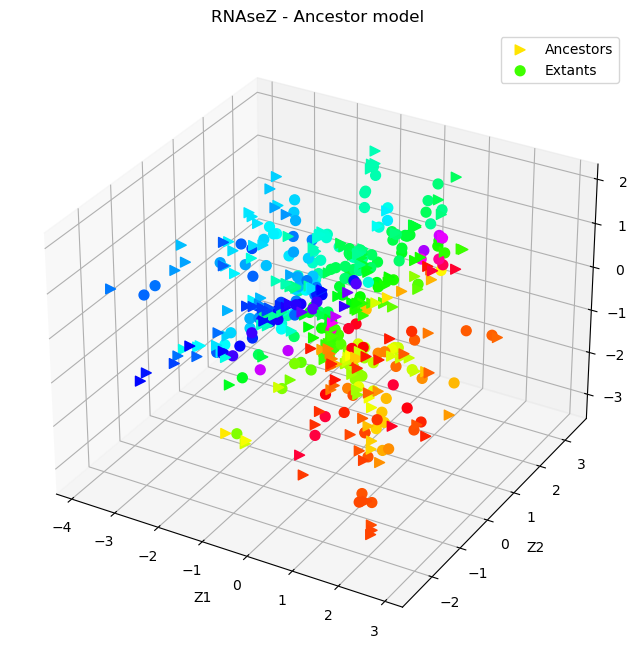

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/cassowary/vis/tree_1_ancestors_extants.fasta
Checking for bad characters: ['B', 'J', 'Z', 'U']
Number of seqs: 485


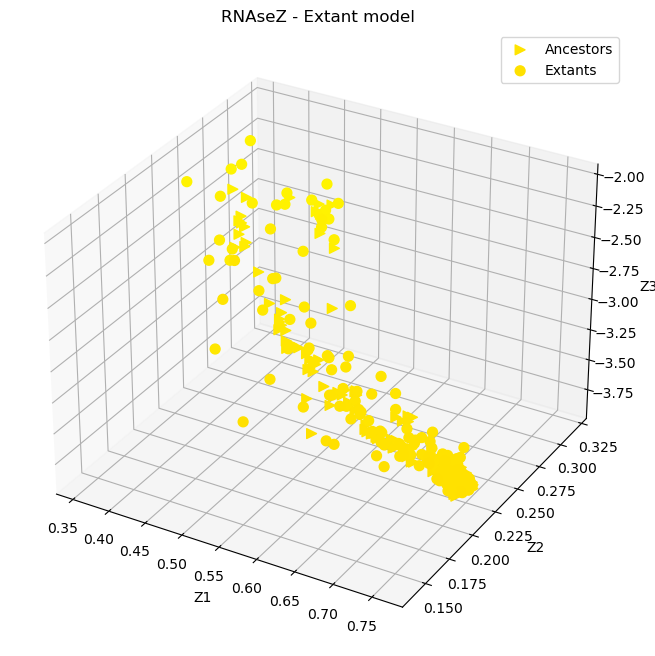

In [3]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/cassowary/vis/"
cass_tree = path + "tree_1_ancestors_extants.fasta"
a_state_dict=  "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/raw_data/cassowary_standard/cassowary_a_r1/cassowary_a_r1_model_state.pt"
e_state_dict = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/raw_data/cassowary_standard/cassowary_e_r1/cassowary_e_r1_model_state.pt"


vs.vis_tree(None, cass_tree, a_state_dict, settings, "RNAseZ - Ancestor model", rgb=True, lower_2d=True)
vs.vis_tree(None, cass_tree, e_state_dict, settings, "RNAseZ - Extant model", rgb=True, lower_2d=True)
vs.vis_tree(None, cass_tree, a_state_dict, settings, "RNAseZ - Ancestor model", rgb=True)
vs.vis_tree(None, cass_tree, e_state_dict, settings, "RNAseZ - Extant model", rgb=True)

In [4]:
vs.latent_tree_to_itol("RNAseZ_ancestor_model", 
                       state_dict="/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/raw_data/cassowary_standard/cassowary_a_r1/cassowary_a_r1_model_state.pt",
                       tree_seq_path=cass_tree,
                       settings=settings)

vs.latent_tree_to_itol("RNAseZ_extant_model", 
                       state_dict="/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/raw_data/cassowary_standard/cassowary_e_r1/cassowary_e_r1_model_state.pt",
                       tree_seq_path=cass_tree,
                       settings=settings)

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/cassowary/vis/tree_1_ancestors_extants.fasta
Checking for bad characters: ['B', 'J', 'Z', 'U']
Number of seqs: 485
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/cassowary/vis/tree_1_ancestors_extants.fasta
Checking for bad characters: ['B', 'J', 'Z', 'U']
Number of seqs: 485


In [5]:

tree = st.read_aln_file(cass_tree)
tree
one_hot = tree["sequence"].apply(st.seq_to_one_hot)
tree["encoding"] = one_hot

device = torch.device("mps")
tree_dataset = MSA_Dataset(
    tree["encoding"],
    pd.Series(np.arange(len(one_hot))),
    tree["id"],
    device=device,
)

num_seqs = len(tree["sequence"])
tree_loader = torch.utils.data.DataLoader(
    tree_dataset, batch_size=num_seqs, shuffle=False
)

seq_len = tree_dataset[0][0].shape[0]
input_dims = seq_len * settings["AA_count"]

model = SeqVAE(
    dim_latent_vars=settings["latent_dims"],
    dim_msa_vars=input_dims,
    num_hidden_units=settings["hidden_dims"],
    settings=settings,
    num_aa_type=settings["AA_count"],
)

state_dict = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/raw_data/cassowary_standard/cassowary_a_r1/cassowary_a_r1_model_state.pt"
model.load_state_dict(torch.load(state_dict, map_location=device))
model = model.to(device)


Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/cassowary/vis/tree_1_ancestors_extants.fasta
Checking for bad characters: ['B', 'J', 'Z', 'U']
Number of seqs: 485


In [6]:
model.eval()
ids = []
mus = [] 
sigmas = []
with torch.no_grad():
    for x, _, name in tree_loader:
        x = torch.flatten(x, start_dim=1)
        mu, sigma = model.encoder(x)
        mus.extend(mu.cpu().numpy())
        sigmas.extend(sigma.cpu().numpy())
        ids.extend(name)
    

In [7]:
coordinates = pd.DataFrame({"id": ids, "mu": mus, "sigma": sigmas})
coordinates

,id,mu,sigma
0,N0_cassowary_tree_1,"[0.708617, 0.6672352, 0.31453118]","[0.018733729, 0.043027334, 0.02513008]"
1,N1_cassowary_tree_1,"[0.5121594, 0.57505757, 0.19093232]","[0.021497773, 0.039191876, 0.027662538]"
2,N2_cassowary_tree_1,"[0.17722063, 0.44260284, 0.15967256]","[0.026644344, 0.033167478, 0.03359597]"
3,N3_cassowary_tree_1,"[0.17510152, 0.9699377, -0.13360429]","[0.033342, 0.037463546, 0.04005424]"
4,N4_cassowary_tree_1,"[0.20061557, 1.3568459, -0.34900868]","[0.040042426, 0.04365334, 0.04197777]"
...,...,...,...
480,tr|A0A4D4INH5|A0A4D4INH5_9ALTE,"[1.6970503, 0.86265785, 1.3507928]","[0.07174783, 0.07285627, 0.054749426]"
481,tr|A0A418YI09|A0A418YI09_9GAMM,"[1.4267019, 1.4068143, 0.7240322]","[0.042504694, 0.06505446, 0.046005256]"
482,tr|A0A2R5F474|A0A2R5F474_9PROT,"[1.0162289, 2.0947113, 1.6038791]","[0.078791305, 0.13609728, 0.100335315]"
483,tr|A0A377SWB5|A0A377SWB5_9NEIS,"[0.95980096, 1.7793307, 1.4410106]","[0.07090196, 0.10575552, 0.0830584]"


In [8]:
def wasserstein_2_distance(mu1: float, sig1: float, mu2: float, sig2: float) -> float:
    """
    Calculates the Wasserstein-2 distance for 2 Gaussians.

    Uses the closed form determined by Givens and Shortt, 1984.
    https://djalil.chafai.net/blog/2010/04/30/wasserstein-distance-between-two-gaussians/

    Assumes that these are 1D Gaussians so standard deviation is given rather than the
    covaraince matrix. 

    Returns:
    Wasserstein-2 distance - note this is a squared value
    """
    
    squared_l2_norm = (mu1 - mu2)**2

    cov_term = sig1**2 + sig2**2 - 2 * ((sig1 * sig2**2 * sig1)**0.5)

    wasserstein = squared_l2_norm + cov_term

    return wasserstein


In [87]:
ids_to_idx = {id: idx for idx, id in enumerate(coordinates["id"])}
idx_to_ids = {idx: id for idx, id in enumerate(coordinates["id"])}

dist_mat = np.zeros((len(ids_to_idx), len(ids_to_idx)))
print(dist_mat.shape)

for i in range(dist_mat.shape[0] - 1):
    for j in range(i + 1, dist_mat.shape[0]):

        dist = np.sqrt(np.sum([wasserstein_2_distance(mu_i, sig_i, mu_j, sig_j) for mu_i, sig_i, mu_j, sig_j in zip(mus[i], sigmas[i],  mus[j], sigmas[j])]))
        #dist = np.mean([wasserstein_2_distance(mu_i, sig_i, mu_j, sig_j) for mu_i, sig_i, mu_j, sig_j in zip(mus[i], sigmas[i],  mus[j], sigmas[j])])
        dist_mat[i, j] = dist_mat[j, i] = dist

(485, 485)


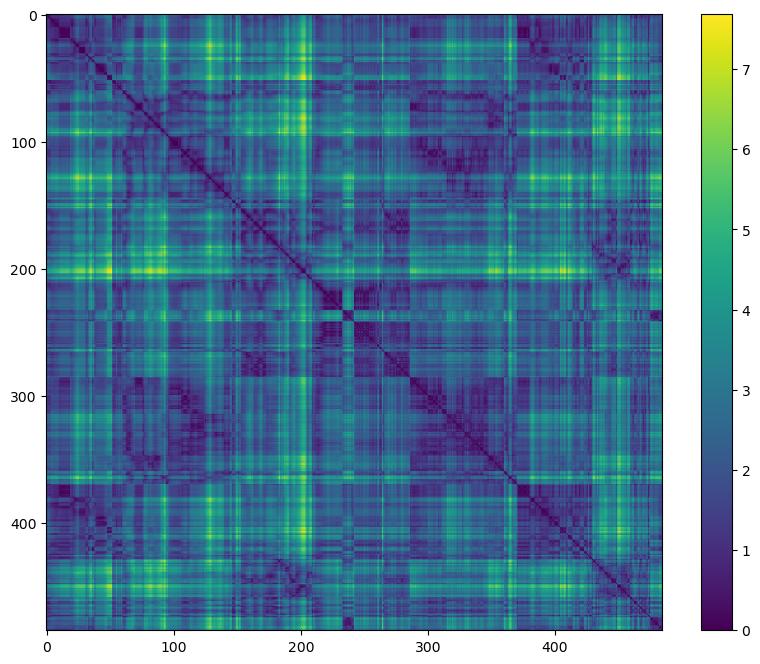

In [92]:
plt.figure(figsize=(10, 8))  # Set the figure size
plt.imshow(dist_mat, cmap='viridis')
plt.colorbar()  # Add a colorbar to show the scale
plt.show()

In [89]:
g = Graph.Weighted_Adjacency(dist_mat.tolist(), mode="undirected", attr="weight")

In [90]:
print("test")
commmunities = g.community_walktrap(weights=g.es['weight'])
for_plot = commmunities.as_clustering()

test


In [91]:

for i, community in enumerate(for_plot):
    print(f"Community {i}:")
    for v in community:
        print(v)

Community 0:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
2

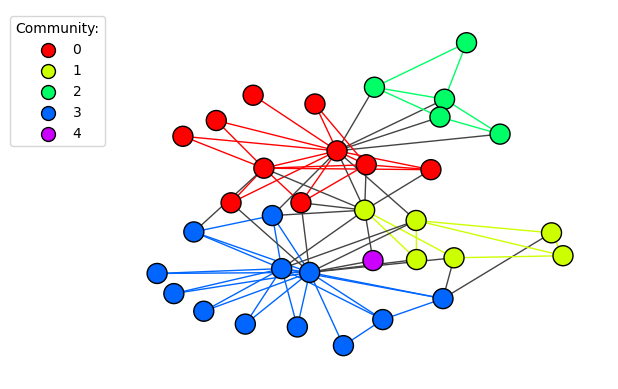

In [50]:
import igraph as ig
import matplotlib.pyplot as plt

g = ig.Graph.Famous("Zachary")
communities = g.community_edge_betweenness()
communities = communities.as_clustering()
num_communities = len(communities)
palette = ig.RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    g.vs[community]["color"] = i
    community_edges = g.es.select(_within=community)
    community_edges["color"] = i

fig, ax = plt.subplots()

ig.plot(
    communities,
    palette=palette,
    edge_width=1,
    target=ax,
    vertex_size=20,
)

# Create a custom color legend
legend_handles = []
for i in range(num_communities):
    handle = ax.scatter(
        [], [],
        s=100,
        facecolor=palette.get(i),
        edgecolor="k",
        label=i,
    )
    legend_handles.append(handle)
ax.legend(
    handles=legend_handles,
    title='Community:',
    bbox_to_anchor=(0, 1.0),
    bbox_transform=ax.transAxes,
)
plt.show()
